# Rating classification using Keras
For this notebook you have to download glove 6B from https://nlp.stanford.edu/projects/glove/ extract and place it inside folder in which you are running this notebook

## Imports

In [1]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import numpy as np
from langdetect import detect
import spacy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


### Helper functions

In [2]:
def positive_negative_reviews(x):
    if x >= 4:
        return 1
    if x <= 2:
        return 0
    else:
        return np.nan

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

## Preprocessing

In [3]:
ds = pd.read_csv('yelp_review.csv')

In [4]:
clean_ds = ds[['stars', 'text']]
clean_ds['label'] = clean_ds['stars'].apply(lambda x: positive_negative_reviews(x)) 
clean_ds = clean_ds[clean_ds['label'].notna()] # 4-5 star review - label = 1, 1-2 star review -label=0
clean_ds = clean_ds[clean_ds['label']==1].head(3300).append(clean_ds[clean_ds['label']==0].head(3300))
clean_ds['language'] = clean_ds['text'].apply(lambda x: detect(x))
clean_ds = clean_ds[clean_ds['language'] == 'en']
np.random.seed(42)
clean_ds = clean_ds.reindex(np.random.permutation(clean_ds.index))
clean_ds['text'] = clean_ds['text'].str.lower()
X = clean_ds['text'].head(3000) # the features we want to analyze
ylabels = clean_ds['label'].head(3000) # the labels, or answers, we want to test against

/home/dub/Projects/o2/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We will train nn. classifier in Keras, which will be used for predicting star rating on unseen text reviews

In [5]:
X = clean_ds['text'].head(3000) # the features we want to analyze
ylabels = clean_ds['label'].head(3000) # the labels, or answers, we want to test against

In [6]:
del clean_ds
del ds

## Keras classification

In the next block of code preprare keras classifier, you need to download glove 6B from https://nlp.stanford.edu/projects/glove/ 

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import GridSearchCV
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=1/3, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = 5000
xtrain = tokenizer.texts_to_sequences(X_train)
xtest = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1


maxlen=100
# Pad sequences with zeros
X_train = pad_sequences(xtrain, padding='post', maxlen=maxlen)
X_test = pad_sequences(xtest, padding='post', maxlen=maxlen)

vocab_size=len(tokenizer.word_index)+1


embedding_dim = 100

# We will use glove for pretrained embeding matrix
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt',tokenizer.word_index, embedding_dim)

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=20))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", 
     metrics=['accuracy'])
model.summary()

    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1477100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,513,157
Trainable params: 1,513,157
Non-trainable params: 0
____________________________________________

## Fitting the model and statistics

/home/dub/Projects/o2/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.8710


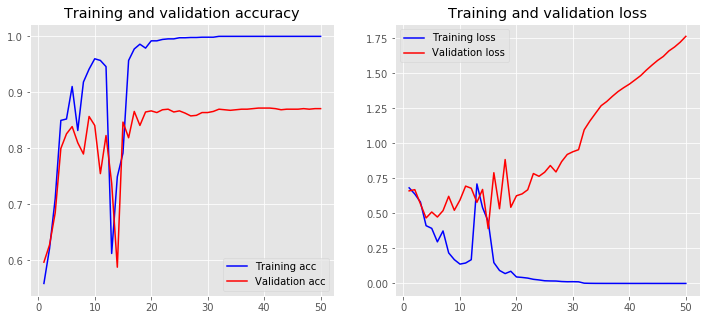

In [8]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
